# A brief study on optimizations of `Ctrl+F`

## Hypothesis

In my experience and intuition `Ctrl+F` functions best when used between words-- e.g. searching a text for `Donald Knuth` takes many letters of typing before arriving at a sufficient result.  Stopping at just `Donald K` could return any number of donalds.  However, searching for `ld Kn` will likely have as-good performance while being faster to type.


I'll make some assumptions.  Probably we are searching for some text for the purpose of navigating an article e.g. to find a specific passage.  The optimal search would be to search for exactly all of the text you want, but this requires you to have the text, rendering the search useless.  Usually these searches are just a few words or maybe a phrase which will produce a (hopefully small) handful of results to skim through until I find what I was looking for.

More formally:

```
t = set(target_text)
|t| = 1

s_n q = "set of text given a query of length n"
s_n ⊆ s_n+1
|s_12 "Donald Knuth"| = N_full
|s_5 "Donal"| = Naive_5
|s_5 "ld Kn"| = Withspace_5

Prediction: |t| <= |Whitespace_n| <= |Naive_n|
```

## Setup

In [1]:
import random
import matplotlib.pyplot as plt
import string
from collections import defaultdict

In [2]:
lipsum = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec turpis nisl, tincidunt quis ligula vitae, hendrerit imperdiet sem. Mauris vel sem eu sem laoreet semper quis in sem. Integer vel diam eget mauris tincidunt bibendum. Aenean fringilla enim convallis velit hendrerit dapibus. Vivamus pretium venenatis lacus, vitae iaculis diam dictum sed. Sed posuere tempus est ut pretium. Aenean posuere erat congue dolor elementum, eu tempus tortor pretium. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Vivamus ornare dui sed urna ultricies semper. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Vivamus nec justo orci. Vestibulum consequat ante posuere massa tristique, id rhoncus augue aliquet. Proin dictum efficitur commodo. Donec purus nibh, accumsan et cursus sed, placerat in nibh.

Aenean dignissim mattis nisl vel aliquam. Nunc ac tortor fringilla, semper augue eget, tristique tellus. Nullam et aliquet tellus, commodo finibus augue. Ut id augue lobortis, posuere eros ac, suscipit elit. Nunc suscipit quis lectus id gravida. Etiam est dui, luctus quis diam vitae, mattis fermentum mauris. Mauris diam quam, scelerisque sed ligula ut, congue feugiat est. Cras interdum non nisl a sodales. Vestibulum vestibulum metus eget orci iaculis suscipit. Quisque varius pharetra eros, in molestie risus ornare id. Phasellus consequat dictum enim, non fringilla diam. Sed non risus vehicula, auctor purus scelerisque, feugiat nulla. Nam sodales tortor sed urna maximus elementum. Vivamus convallis ex vel magna hendrerit tincidunt. Sed non quam id tellus semper lobortis. Duis auctor diam eu sagittis aliquam.

Suspendisse ullamcorper at risus varius scelerisque. Morbi aliquet at nibh eget elementum. In turpis metus, dapibus ac mauris eget, aliquam efficitur nunc. Nam faucibus efficitur quam ac mollis. Mauris id maximus tellus. Proin congue ligula varius augue hendrerit, quis molestie felis facilisis. Curabitur dapibus massa luctus, efficitur eros quis, volutpat odio. Aliquam sit amet molestie risus, vel laoreet erat. Integer tortor enim, faucibus ut semper eget, porta id nunc. Quisque mattis lectus at nunc tincidunt accumsan. Nulla tincidunt scelerisque sem in vulputate. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos.

Phasellus nisi dui, rutrum posuere odio hendrerit, convallis tincidunt mauris. Vestibulum sollicitudin viverra neque, faucibus condimentum odio auctor ut. Sed tempor, mi sed euismod blandit, nisl felis vehicula lectus, non cursus enim diam sodales urna. Proin scelerisque turpis eu facilisis facilisis. Vivamus elementum elit sit amet est convallis sollicitudin. Curabitur blandit convallis eros. Sed congue quis nisi ornare ornare. Vestibulum ut interdum nisi. Mauris lobortis quam at aliquet sagittis. Etiam tempor commodo risus sit amet cursus. Nullam bibendum ornare dolor, et pellentesque lacus bibendum a. Lorem ipsum dolor sit amet, consectetur adipiscing elit.

In hac habitasse platea dictumst. In viverra massa eget arcu vestibulum, at pretium risus maximus. Duis sapien dolor, elementum et lacinia quis, pellentesque eu urna. Vivamus hendrerit ex et ante interdum, ac dignissim orci vehicula. Duis vitae pellentesque est. Duis maximus, velit ac suscipit mattis, neque mauris vulputate quam, eu dictum augue purus varius augue. Interdum et malesuada fames ac ante ipsum primis in faucibus. Duis porta a felis non semper. Proin id mollis risus. In hac habitasse platea dictumst. Duis et tellus eget orci feugiat fermentum. Nam mollis quis sem a vulputate. Nullam laoreet tempus nulla ut malesuada."""

In [3]:
contents = ""
paths = [
    "/content/drive/MyDrive/Colab Notebooks/colaboratory-data/tkam.txt",
    "/content/drive/MyDrive/Colab Notebooks/colaboratory-data/bible.txt",
]
for path in paths:
  with open(path, "r") as file:
    contents += file.read()

## Analyzing Character Frequency

In [4]:
def substrings(n, xs):
    if len(xs) < n:
        return []
    else:
        return [xs[i:i+n] for i in range(len(xs) - n + 1)]

Here are some example searches one might make over some text

In [5]:
list(substrings(3, lipsum))[30:40]

['nse', 'sec', 'ect', 'cte', 'tet', 'etu', 'tur', 'ur ', 'r a', ' ad']

In [6]:
def count_substrings(subs):
    counts = defaultdict(int)
    for sub in subs:
        counts[sub] += 1
    return counts

And we can see how many times substrings appear.

In [7]:
cs = count_substrings(substrings(3, lipsum))
for c in list(cs)[:10]:
    print(c, cs[c])

Lor 2
ore 5
rem 2
em  6
m i 4
 ip 3
ips 3
psu 3
sum 3
um  24


### Analysis

Let us visualize the distribution of letters in our text

In [8]:
def analyze_substrings(n, contents, first_n = None):
  fig, axs = plt.subplots(1, 2, figsize=(25, 5))

  grams = substrings(n, contents)
  letters = set(string.ascii_letters + " ,.+-='\":;<>?/\\|*")

  letters = [letter for letter in letters if letter in contents]
  if first_n is None:
    first_n = len(letters)

  overlap_counts = {}

  for letter in letters:
    words_with_letter = [word for word in grams if letter in word]

    unique_words_with_letter = set(words_with_letter)
    overlap_counts[letter] = len(words_with_letter) - len(unique_words_with_letter)

  sorted_letters = sorted(overlap_counts, key=overlap_counts.get)

  axs[0].bar(sorted_letters[:first_n], [overlap_counts[letter] for letter in sorted_letters][:first_n])
  axs[0].set_xlabel("Letter")
  axs[0].set_ylabel("Number of Overlapping Words")
  axs[0].set_title("Number of Overlapping Words for Each Letter")

  letter_diversity = {}
  for letter in letters:
    words_with_letter = [word for word in grams if letter in word]
    if len(words_with_letter) == 0:
      letter_diversity[letter] = 0
      continue
    unique_words_with_letter = set(words_with_letter)
    letter_diversity[letter] = len(unique_words_with_letter) / len(words_with_letter)

  sorted_letters = sorted(letter_diversity, key=letter_diversity.get)

  axs[1].bar(sorted_letters[:first_n], [letter_diversity[letter] for letter in sorted_letters][:first_n])
  axs[1].set_xlabel("Letter")
  axs[1].set_ylabel("Diversity")
  axs[1].set_title("Diversity of Words for Each Letter")

  plt.show()

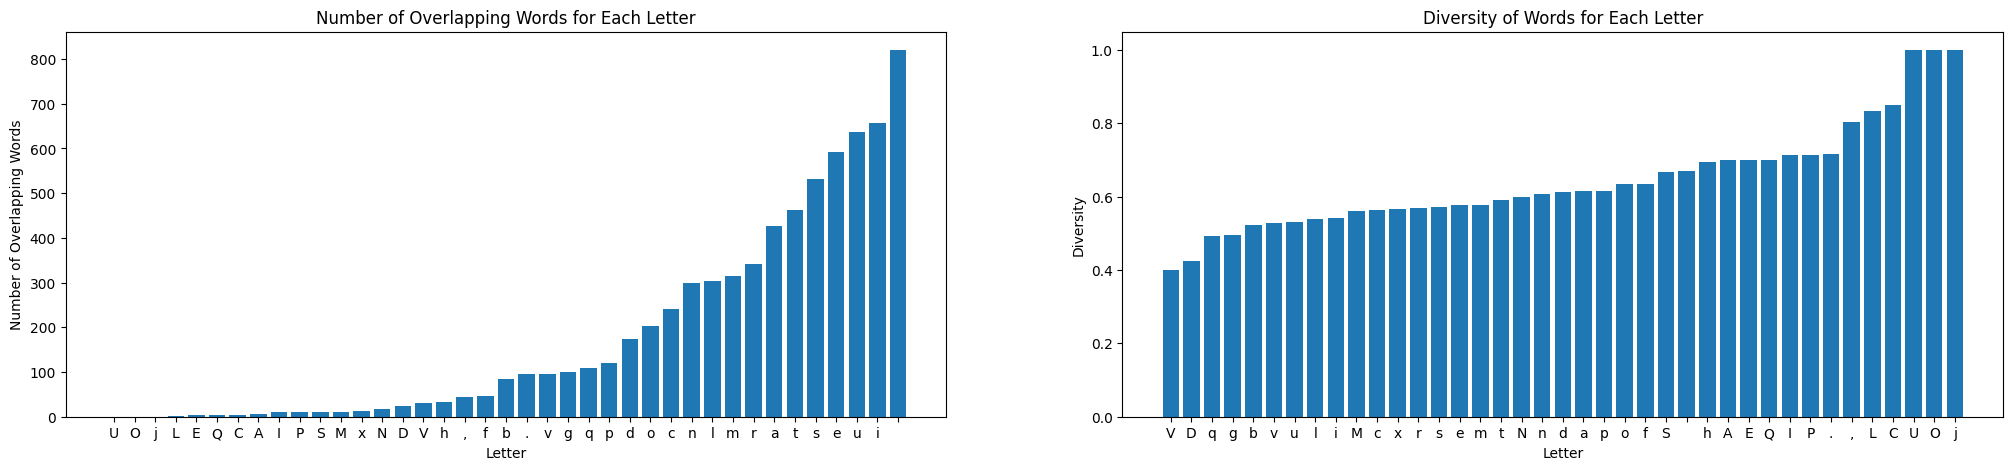

In [9]:
analyze_substrings(5, lipsum) # on our smaller text

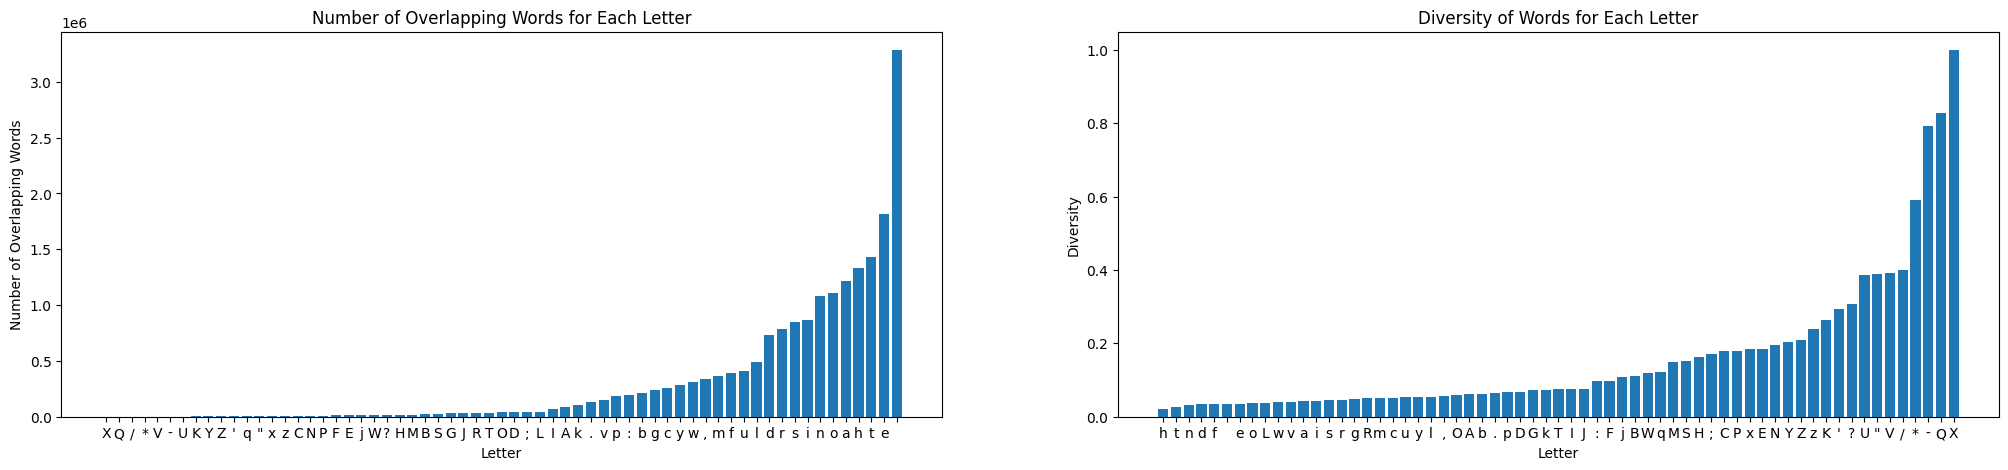

In [10]:
analyze_substrings(5, contents) # and the larger text

### Observations

1. The most common character (by far) is the space `' '` character
2. The most diverse characters are capital letters and symbols

To me this demonstrates the following

1. Searching a text for a handful of characters will perform better (i.e. fewer false positives) when it contains a non-letter character
2. The space character is the best performing non-letter character by far-- appearing in more substrings than others `,.`
3. Case-sensitive search can yield significant benefit

## A Case Study

We shall select some word pairs from the text and find uniqueness of these pairs, then compare this with uniqueness of a substring of each pair which contains a space.

In [11]:
def find_n_surrounding_words(s, num_words, n=10):
  s = s.split(' ')

  rands = set()
  if len(s)-num_words < n:
    rands = range(len(s)-num_words+1)
  else:
    while len(rands) < n:
      rands.add(random.randint(0, len(s) - num_words - 1))

  surrounding_words = []
  for index in rands:
    # index = random.randint(0, len(s) - num_words - 1)

    start_index = max(0, index)
    end_index = min(len(s), index + num_words)
    words = ' '.join(s[start_index:end_index])

    surrounding_words.append((index, words))

  return surrounding_words

s = "This is a sample sentence with some words."
num_words = 2
surrounding_words = find_n_surrounding_words(s, num_words, 4)

for index, words in surrounding_words:
  print(f"Index: {index}, Words: {words}")

Index: 0, Words: This is
Index: 3, Words: sample sentence
Index: 4, Words: sentence with
Index: 5, Words: with some


In [12]:
def letters_surrounding(w, m=3, c=' '):
  n = w.index(c)
  i = m // 2
  j = m - i
  i = max(0,n-i)
  j = min(len(w),n+j)
  while j-i < m:
    if i==0:
      j += 1
    else:
      i -= 1
  return w[max(0,i):min(len(w),j)]

In [13]:
word = surrounding_words[0][1]
word

'This is'

In [14]:
(letters_surrounding(word,3), letters_surrounding(word,7))

('s i', 'This is')

In [15]:
def split_string_into_n_words(string, n):
  words = string.split(' ')
  split_strings = []
  for i in range(0, len(words)-n+1):
    split_strings.append(' '.join(words[i:i + n]))
  return split_strings

s = "This is a sample sentence with some words."
n = 2
split_strings = split_string_into_n_words(s, n)

print(split_strings)

['This is', 'is a', 'a sample', 'sample sentence', 'sentence with', 'with some', 'some words.']


In [16]:
def count_substring_occurrences(string, substring):
  count = 0
  index = string.find(substring)
  while index != -1:
    count += 1
    index = string.find(substring, index + 1)
  return count

s = "This is a sample sentence with some sample words."
substring = "sample"
count = count_substring_occurrences(s, substring)
print(f"The substring '{substring}' occurs {count} times in the string '{s}'.")

The substring 'sample' occurs 2 times in the string 'This is a sample sentence with some sample words.'.


In [17]:
def count_len_pairs(n_values, idxs, text, c=' '):
  len_pairs = []
  for n in n_values:
    lp = []
    for idx, word in idxs:
      substr = letters_surrounding(word, n, c)
      word_n = count_substring_occurrences(text, word)
      naive_word = word[:n]
      sub_n = count_substring_occurrences(text, substr)
      naive_n = count_substring_occurrences(text, naive_word)
      # print(f"{idx:<5}: word='{word:<20}' n={word_n:<5}, sub='{substr:<10}' n={sub_n:<5}, naive='{naive_word:<10}' n={naive_n:<5}")
      lp.append((word, word_n, substr, sub_n, naive_word, naive_n))
    len_pairs.append(lp)
  return len_pairs

In [18]:
def analyze_searches(n_values, len_pairs):
  diff_counts = []
  diff_counts_naive = []
  for i,n in enumerate(n_values):
    cnt = 0
    naive_cnt = 0
    for w, w_n, substr, sub_n, naive_word, naive_n in len_pairs[i]:
      cnt += (sub_n - w_n)
      naive_cnt += (naive_n - w_n)
    diff_counts.append(cnt)
    diff_counts_naive.append(naive_cnt)

  fig, axs = plt.subplots(1, 2, figsize=(25, 5))

  bar_width = 0.5
  x_pos = [i for i in n_values]
  naive_x = [i - (bar_width/2) for i in x_pos]
  sub_x = [i + (bar_width/2) for i in x_pos]

  axs[0].bar(naive_x, diff_counts_naive, bar_width, label="Naive")
  axs[0].bar(sub_x, diff_counts, bar_width, label="With Space")
  axs[0].set_xlabel("Number of Characters")
  axs[0].set_ylabel("Count")
  axs[0].set_title("Count of Occurrences - Occurrences of Full Words")
  axs[0].legend()

  percent_diffs = [(diff_counts_naive[i] - diff_counts[i]) / ((diff_counts_naive[i] + diff_counts[i]) / 2) * 100 for i in range(len(n_values))]

  axs[1].bar(n_values, percent_diffs)
  axs[1].set_xlabel("Number of Characters")
  axs[1].set_ylabel("% Increase in Superfluous Matches")
  axs[1].set_title("Percentage Difference in Occurrences (Naive vs spaces)")

  plt.show()

In [19]:
n_values = range(3, 9)
idxs = find_n_surrounding_words(lipsum, 2, 250)
len_pairs = count_len_pairs(n_values, idxs, lipsum)
len_pairs[3][:10]

[('dictumst. Duis', 1, 'st. Du', 2, 'dictum', 6),
 ('ipsum dolor', 2, 'sum do', 2, 'ipsum ', 3),
 ('dolor sit', 2, 'lor si', 2, 'dolor ', 3),
 ('tellus eget', 1, 'lus eg', 1, 'tellus', 5),
 ('amet, consectetur', 2, 'et, co', 2, 'amet, ', 2),
 ('consectetur adipiscing', 2, 'tur ad', 2, 'consec', 2),
 ('adipiscing elit.', 2, 'ing el', 2, 'adipis', 2),
 ('elit. Donec', 1, 'it. Do', 1, 'elit. ', 2),
 ('turpis nisl,', 1, 'pis ni', 1, 'turpis', 4),
 ('quis sem', 1, 'uis se', 1, 'quis s', 1)]

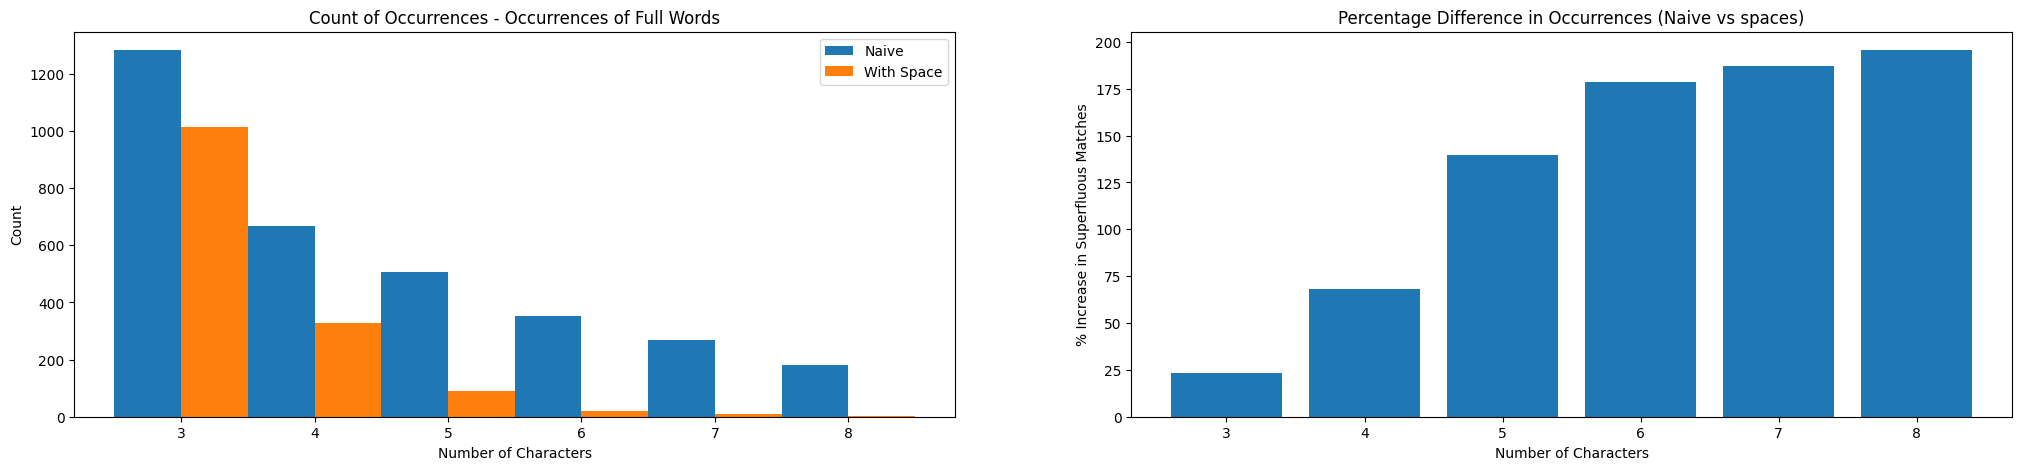

In [20]:
analyze_searches(n_values, len_pairs)

Indeed the number of superfluous matches for naive searches is much greater than searches containing a space character.

Strangely, the difference in results increases dramatically as the search length increases

In [21]:
target = contents
idxs = find_n_surrounding_words(target, 2, 1000)
n_values = range(4, 16)
len_pairs = count_len_pairs(n_values, idxs, target)
len_pairs[3][:10]

[('on thy', 115, 'on thy', 115, 'on thy', 115),
 ('to pass,', 380, 'to pass', 659, 'to pass', 659),
 ('more that', 3, 'ore tha', 131, 'more th', 121),
 ('as he', 297, 'as he', 297, 'as he', 297),
 ('ye were', 41, 'ye were', 41, 'ye were', 41),
 ('forth his', 49, 'rth his', 49, 'forth h', 67),
 ('the sons', 498, 'the son', 1758, 'the son', 1758),
 ('ye shall', 620, 'ye shal', 620, 'ye shal', 620),
 ('if any', 67, 'if any', 67, 'if any', 67),
 ('Egypt were', 2, 'ypt wer', 2, 'Egypt w', 17)]

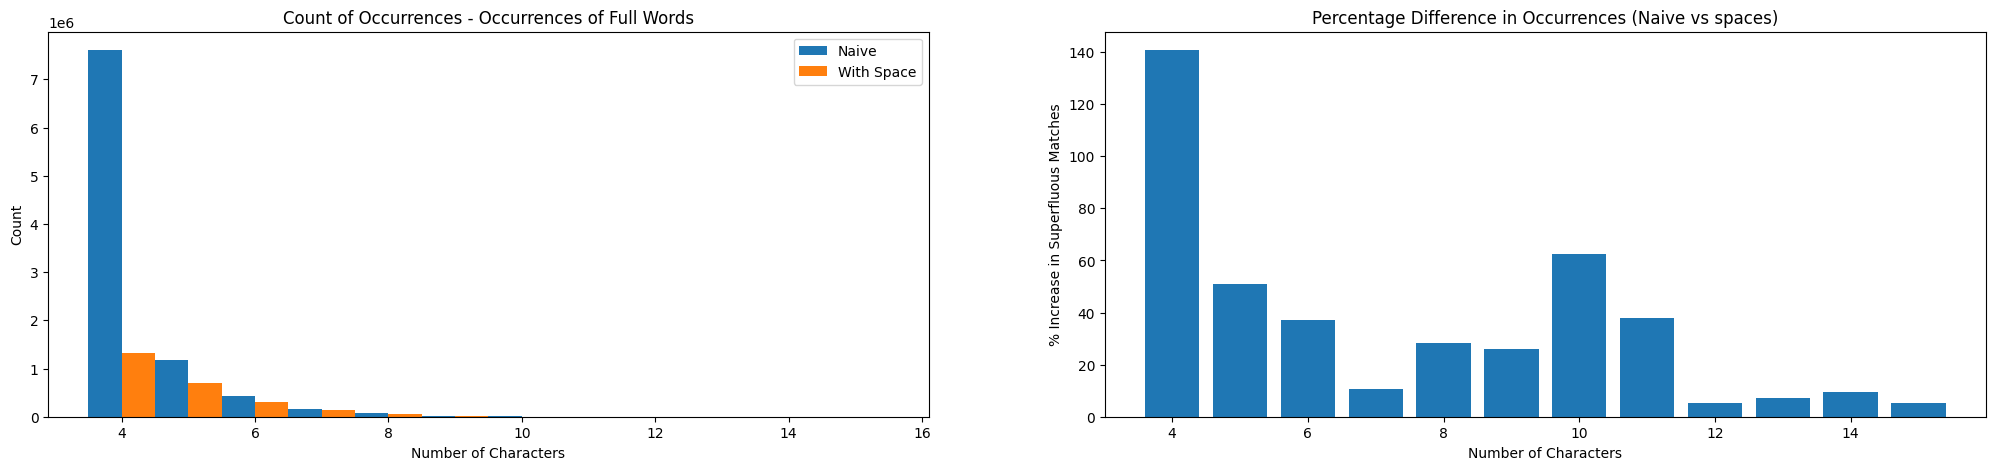

In [22]:
analyze_searches(n_values, len_pairs)

### Observations

It is clear that there is a speedup compared to searching starting from the first letter of the word

## Results

Clearly searching text with spaces in it yields more precise results when compared with searching starting from the beginning of the word, especially for smaller strings (3-5 characters) with diminishing returns

## Summary

We have found a significant (>50% for strings of length less than 6) reduction in superfluous results when searching for pieces of text containing a space when compered with searching for the same number of characters starting from the beginning of the first word (e.g. `ld Kn` vs `Donal`) when comparing 1000 samples of text from The Bible and To Kill a Mockingbird, with few cases in which it performs worse.

This only proves the superiority of one search when compared with a naive search, it is possible that another method of searching is more optimal than the either of the two discussed here.

In [25]:
!jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/document-search.ipynb' --to html --embed-images --theme dark

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/document-search.ipynb to html
[NbConvertApp] Writing 867251 bytes to /content/drive/MyDrive/Colab Notebooks/document-search.html
